In [227]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set('notebook')
import numpy as np
params = {'legend.fontsize': 'large',
          'figure.figsize': (16, 9),
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
plt.rcParams.update(params)

In [228]:
models = ['b-densenet', 'b-resnet', 'msdnet']
tests = ['confidence', 'score-margin']
nets = { model : {test : {} for test in tests} for model in models}
nets['b-densenet']['confidence'] = pd.read_csv('densenet100_confidence.csv', index_col=0)
nets['b-densenet']['score-margin'] = pd.read_csv('densenet100_score_margin.csv', index_col=0)

nets['b-resnet']['confidence'] = pd.read_csv('resnet101_confidence1.csv', index_col=0)
nets['b-resnet']['score-margin'] = pd.read_csv('resnet101_score_margin1.csv', index_col=0)

nets['msdnet']['confidence'] = pd.read_csv('msdnet_confidence1.csv', index_col=0)
nets['msdnet']['score-margin'] = pd.read_csv('msdnet_score_margin1.csv', index_col=0)

nets['msdnet']['score-margin']

threshold  test  exit  sample  exited  prediction  target  correct  \
0             0.1     0     0       0       1           0       0     True   
1             0.1     0     1       0       1           0       0     True   
2             0.1     0     2       0       1           0       0     True   
3             0.1     0     3       0       1           0       0     True   
4             0.1     0     4       0       1           0       0     True   
...           ...   ...   ...     ...     ...         ...     ...      ...   
224995        0.9     8     0    4999       0          99      99     True   
224996        0.9     8     1    4999       0          99      99     True   
224997        0.9     8     2    4999       0          99      99     True   
224998        0.9     8     3    4999       1          99      99     True   
224999        0.9     8     4    4999       1          99      99     True   

               score  
0       9.762708e-01  
1       9.986612e-01  
2       9.996271e-01  
3       9.995337e-01  
4       9.999839e-01  
...              ...  
224995  2.066259e-08  
224996  5.828463e-07  
224997  1.685685e-08  
224998  1.860668e-08  
224999  3.206587e-08  

[225000 rows x 9 columns]

In [229]:
def analyze_df(models, exits):
    tests = ['confidence', 'score-margin']
    data = {
        model : {
            test : {
                'exited' : {},
                'correct' : {},
                'incorrect': {},
                'accuracy': {}
            }
            for test in tests
        }
        for model in models
    }
    
    for model, n in zip(models, exits):
        for test in models[model]:
            for exit in range(n):
                exited = []
                accuracy = []
                correct = []
                incorrect = []
                for t in np.arange(0.1, 1, 0.1):
                    n_exited = len(models[model][test].loc[(models[model][test]['threshold'] == t) 
                                             & (models[model][test]['exit'] == exit)
                                             & (models[model][test]['exited']==1)])
                    exited.append(n_exited)
                    
                    correct.append((len(models[model][test].loc[(models[model][test]['threshold'] == t) 
                                                            & (models[model][test]['exit'] == exit) 
                                                            & (models[model][test]['correct'] == 1) 
                                                            & (models[model][test]['exited']==1)])))
                    incorrect.append((len(models[model][test].loc[(models[model][test]['threshold'] == t) 
                                                    & (models[model][test]['exit'] == exit) 
                                                    & (models[model][test]['correct'] == 0) 
                                                    & (models[model][test]['exited']==1)])))
                    
                    accuracy.append(len(models[model][test].loc[(models[model][test]['threshold'] == t) 
                                                  & (models[model][test]['exit'] == exit) 
                                                  & (models[model][test]['exited']==1) 
                                                  & (models[model][test]['correct']==1)])/n_exited)
                    
                data[model][test]['exited']['exit-{}'.format(exit)] = exited
                #th_exit_acc.append(exit_n_acc)
                #th_false_if_exited.append(exit_n_false)
                data[model][test]['accuracy']['exit-{}'.format(exit)] = accuracy
                #th_time.append(exit_time)
                data[model][test]['correct']['exit-{}'.format(exit)]  = correct
                data[model][test]['incorrect']['exit-{}'.format(exit)] = incorrect

    
    return data
    

In [230]:
output = analyze_df(nets, exits=[4, 4, 5])

## number of exited by threshold

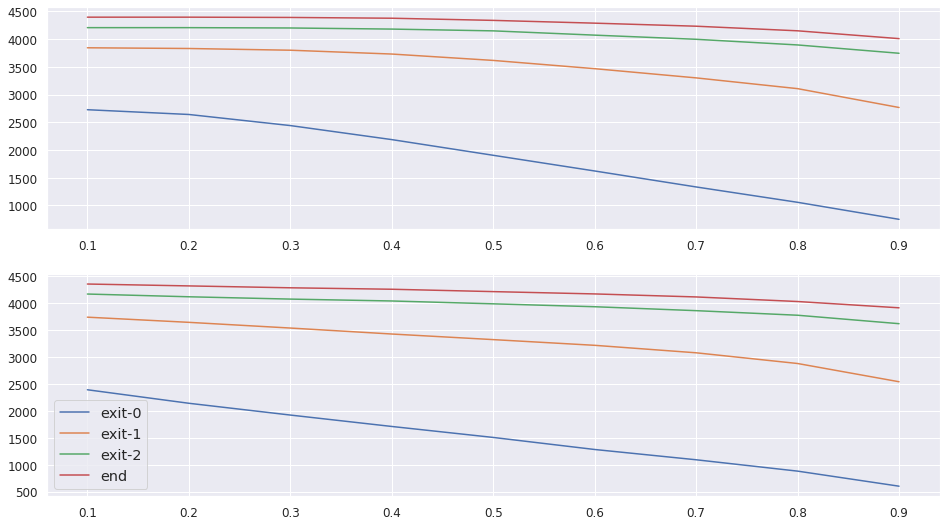

In [45]:

fig, axes = plt.subplots(2, figsize=(16,9))

for d in data[0][0]:
    axes[0].plot(x, d)
    #plt.xticks()

for d in data[0][3]:
    axes[1].plot(x, d)
    #plt.xticks()
plt.legend(['exit-0', 'exit-1', 'exit-2', 'end'])
plt.show()

## falsely exited

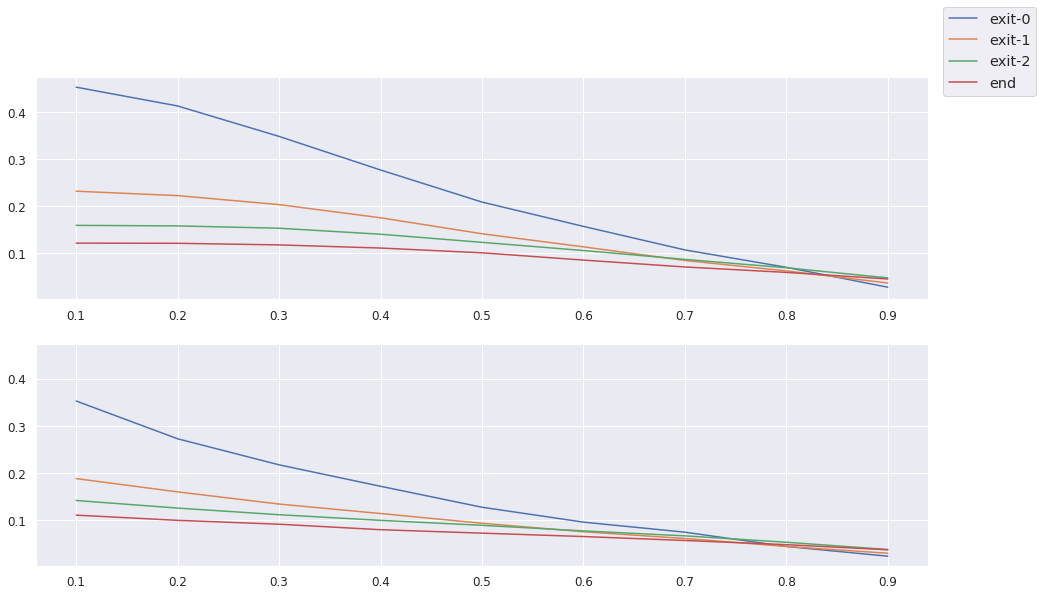

In [13]:

fig, axes = plt.subplots(2, sharey=True)

for data in th_false_if_exited:
    axes[0].plot(x, data)

for data in sm_false_if_exited:
    axes[1].plot(x, data)
    #plt.xticks()
fig.legend(['exit-0', 'exit-1', 'exit-2', 'end'])
plt.show()

## accuracy only if exited

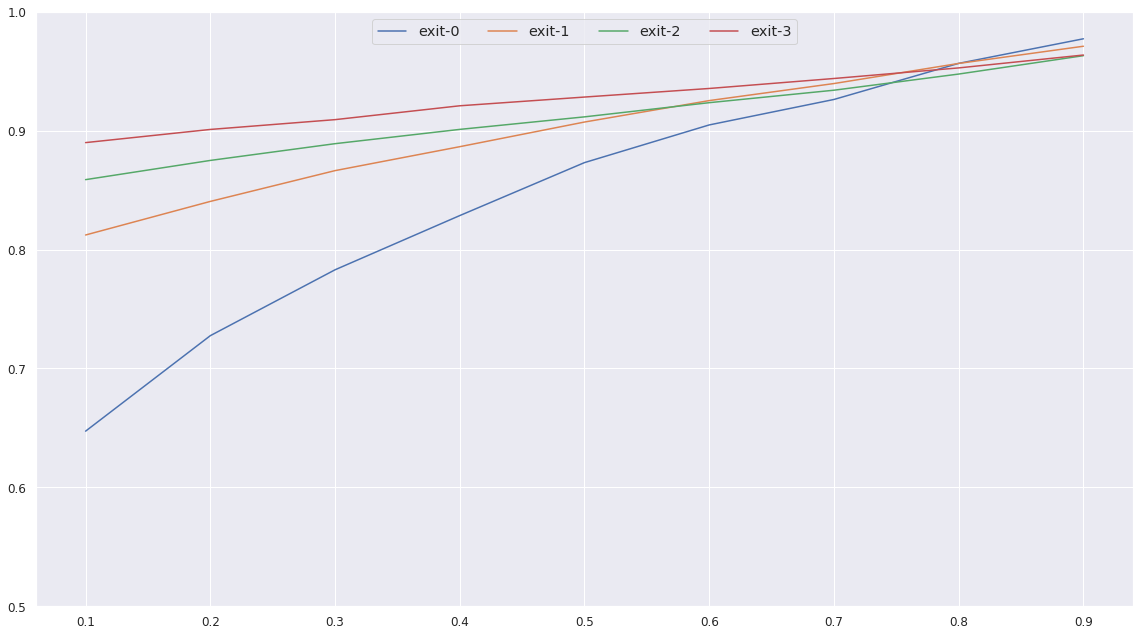

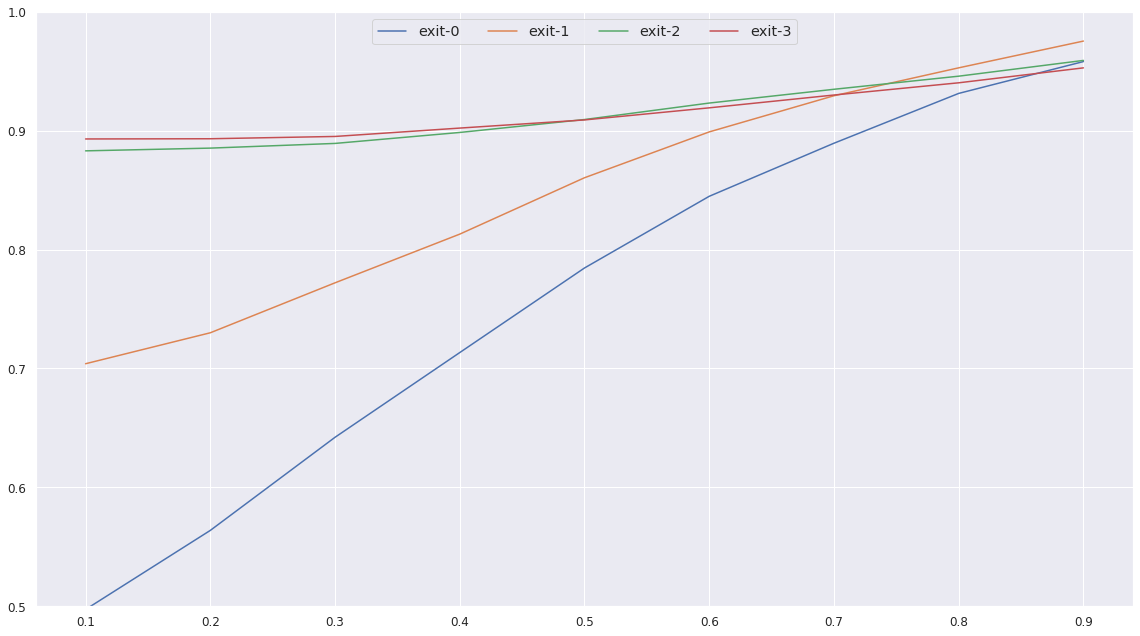

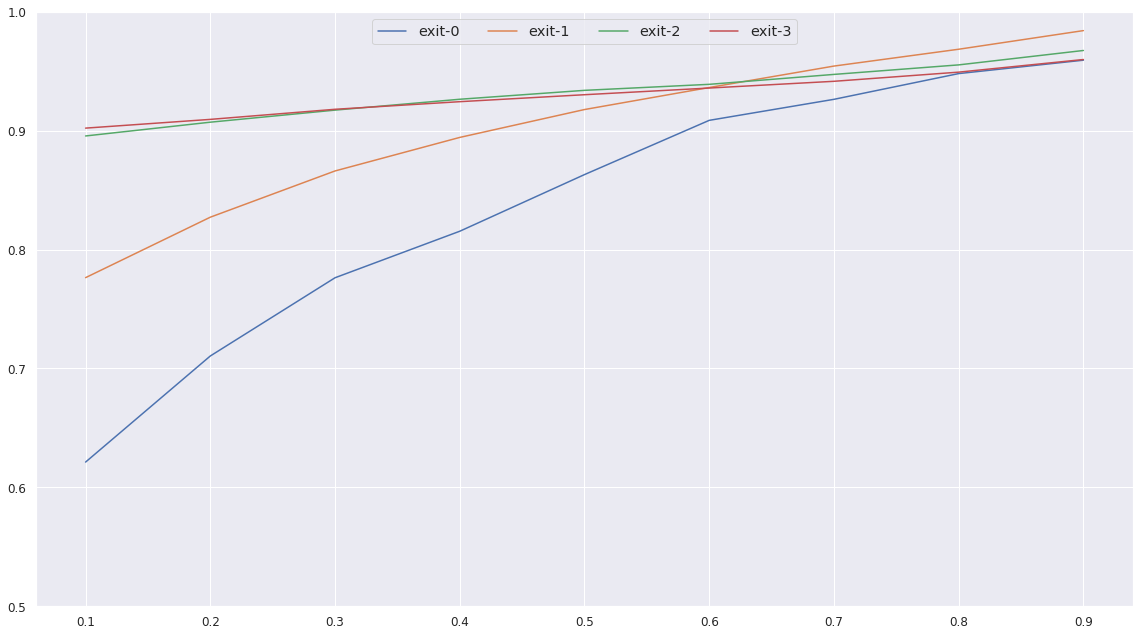

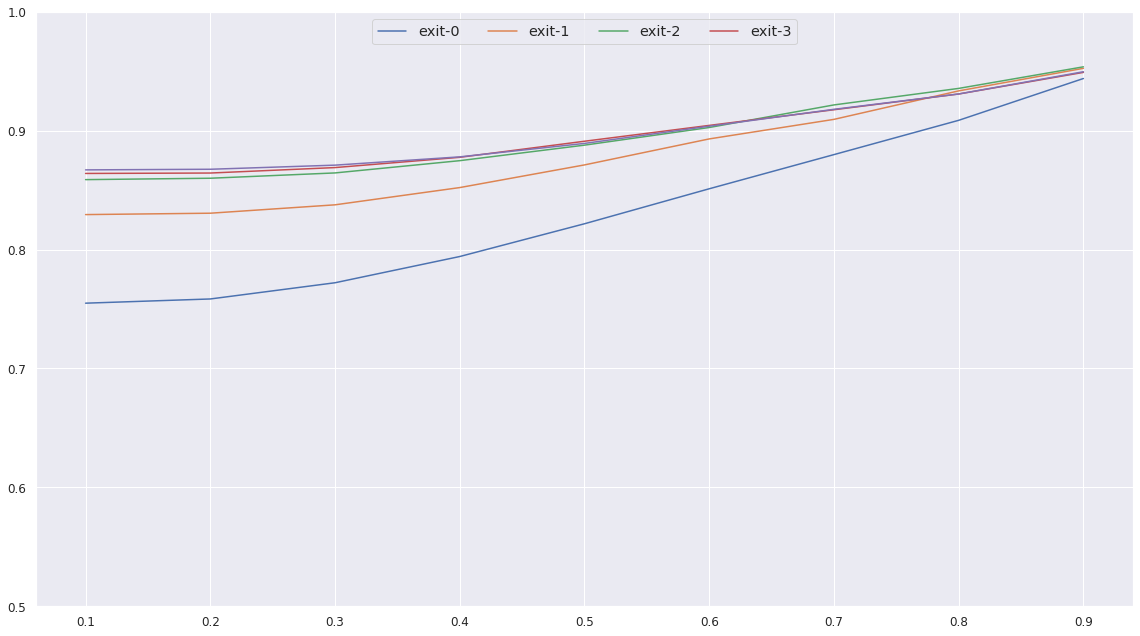

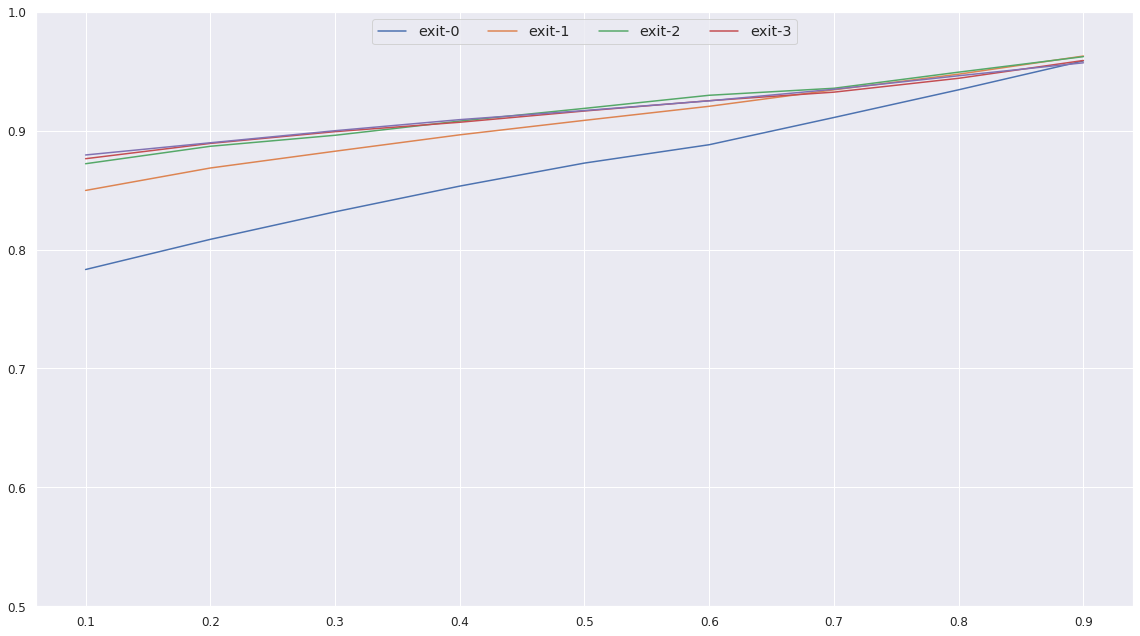

In [232]:
for model in output:
    for test in output[model]:
        fig, ax = plt.subplots(1,1, figsize=(16,9), sharex=True, sharey=True)
        plt.setp(ax, xticks=N, xticklabels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
        for exit in range(len(output[model][test]['correct'])):
            accuracy = np.array(output[model][test]['accuracy']['exit-{}'.format(exit)])
            ax.plot(accuracy)
            ax.set_ylim([0.5, 1])
            plt.legend(['exit-{}'.format(x) for x in range(4)], loc='upper center', #bbox_to_anchor=(0.5, 1.1),
          fancybox=True, shadow=False, ncol=4, fontsize='large')
            fig.tight_layout()
            #fig.subplots_adjust(left=0.15, top=0.95)
        plt.savefig('confidence_analysis_{}_{}_{}.png'.format(model, test, exit))

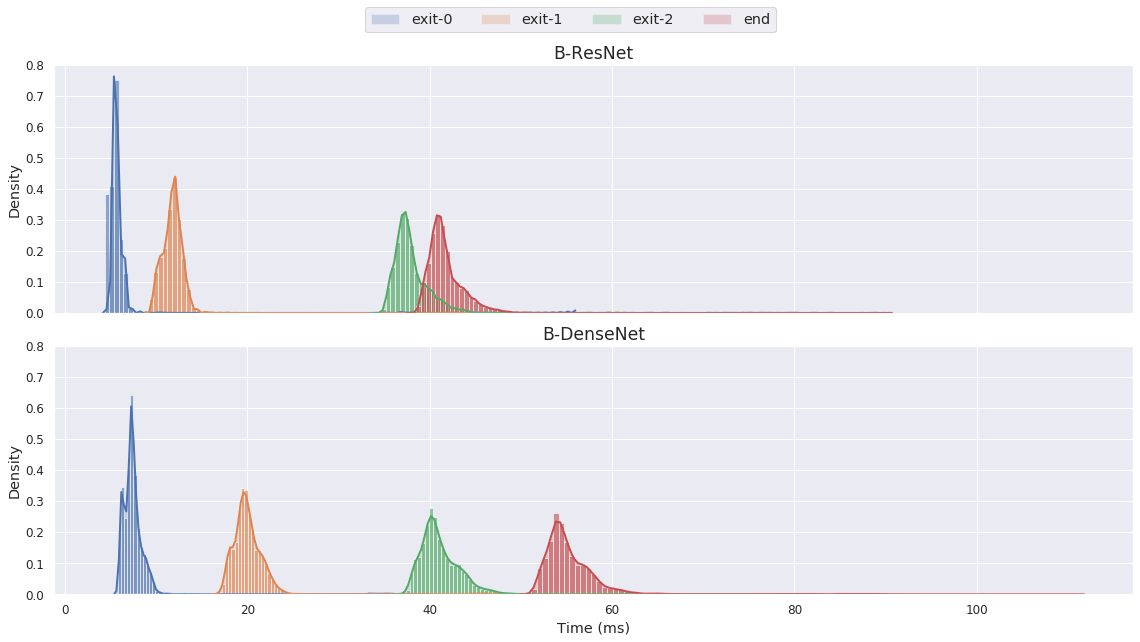

In [113]:
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2, 'shade': True}, hist=True, kde=True, bins=100)
fig, axes = plt.subplots(2,1, sharex=True, sharey=True)
for exit in range(0,4):
    sns.distplot(data[1][2][exit][0][35:180001], ax=axes[0], **kwargs)
    sns.distplot(data[0][5][exit][0][35:180001], ax=axes[1], **kwargs)
fig.legend(['exit-0', 'exit-1', 'exit-2', 'end'], loc='upper center', #bbox_to_anchor=(0.5, 1.1),
          fancybox=True, shadow=False, ncol=4, fontsize='large')
plt.xlabel('time (ms)')
plt.ylabel('density')
fig.tight_layout()
fig.subplots_adjust(top=0.90)
axes[0].set_title('B-ResNet')
axes[1].set_title('B-DenseNet')
for a in axes.flat:
    a.set(xlabel='Time (ms)', ylabel='Density')
    a.label_outer()
plt.savefig('timing.png')

/home/ajk/.conda/envs/master/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


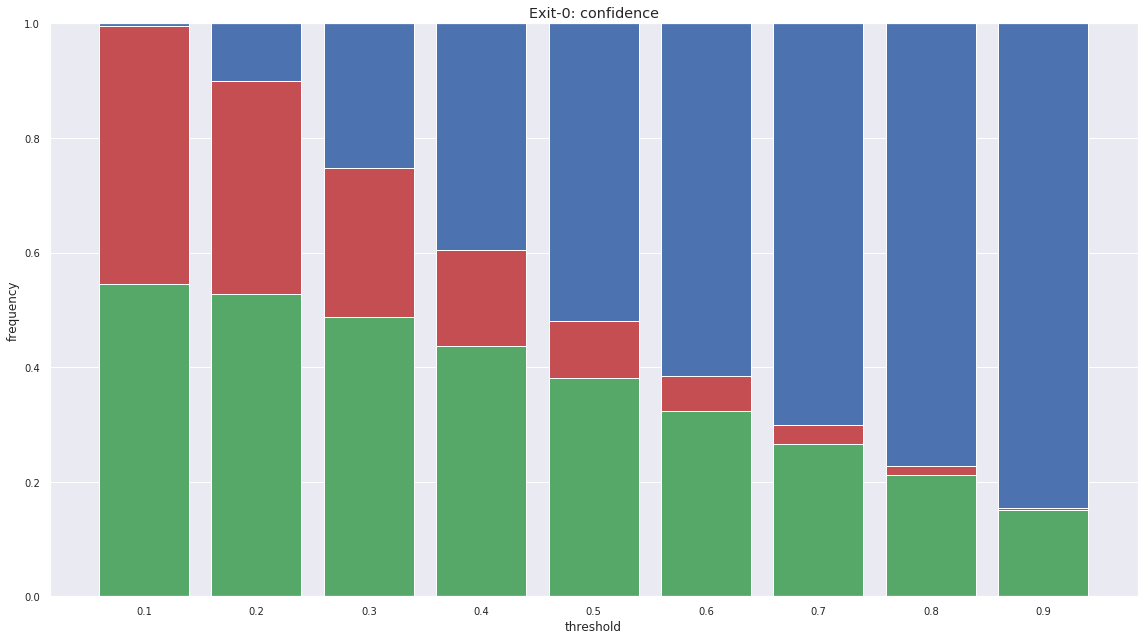

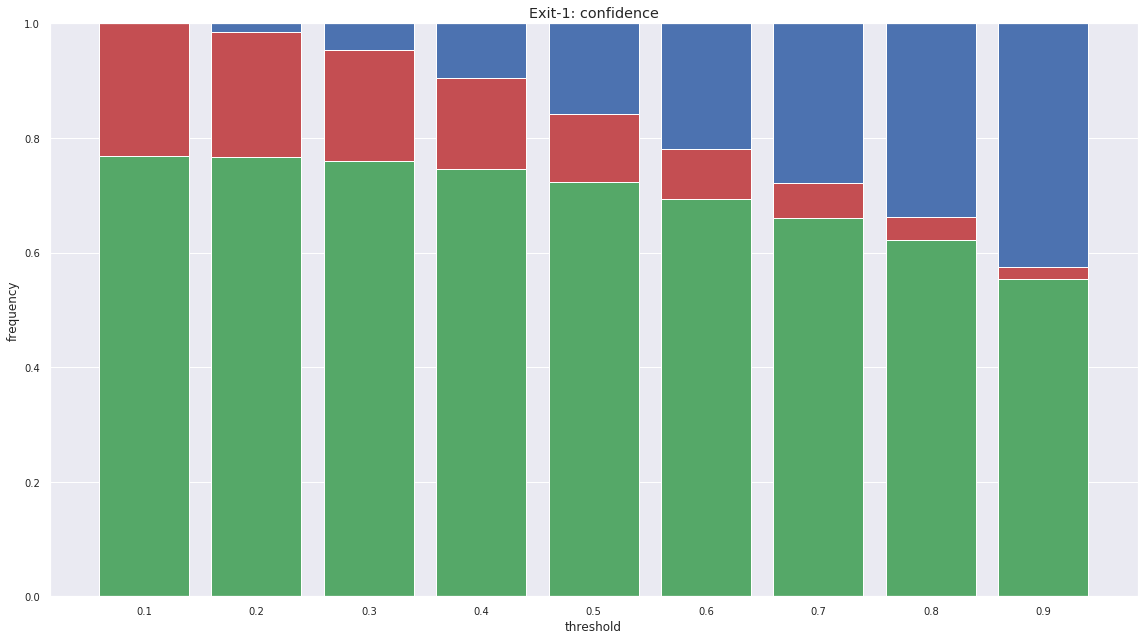

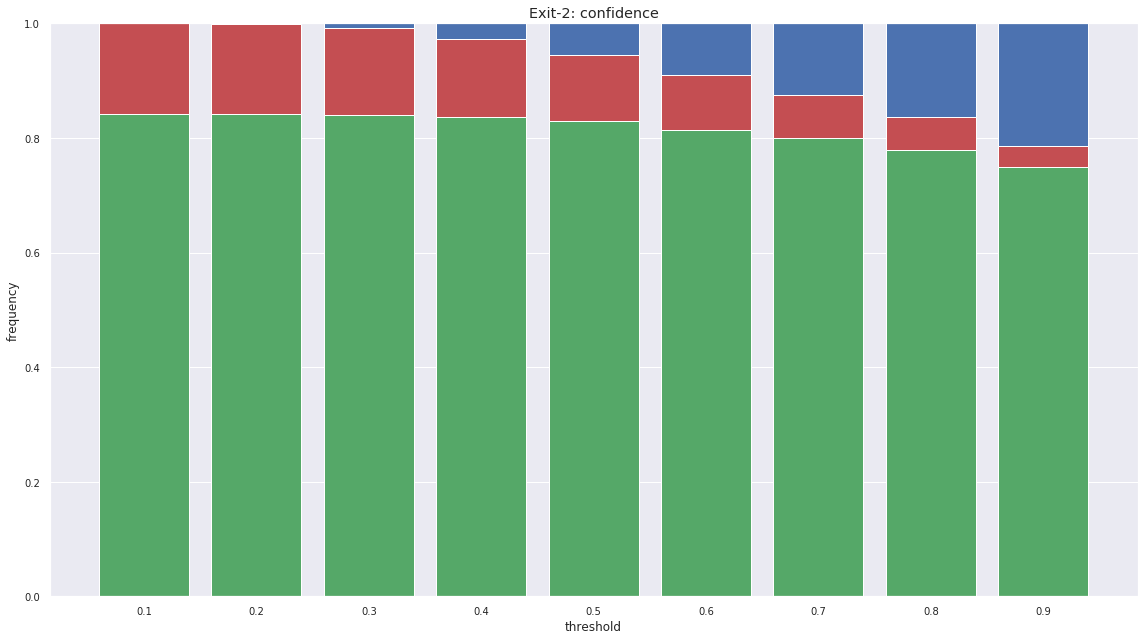

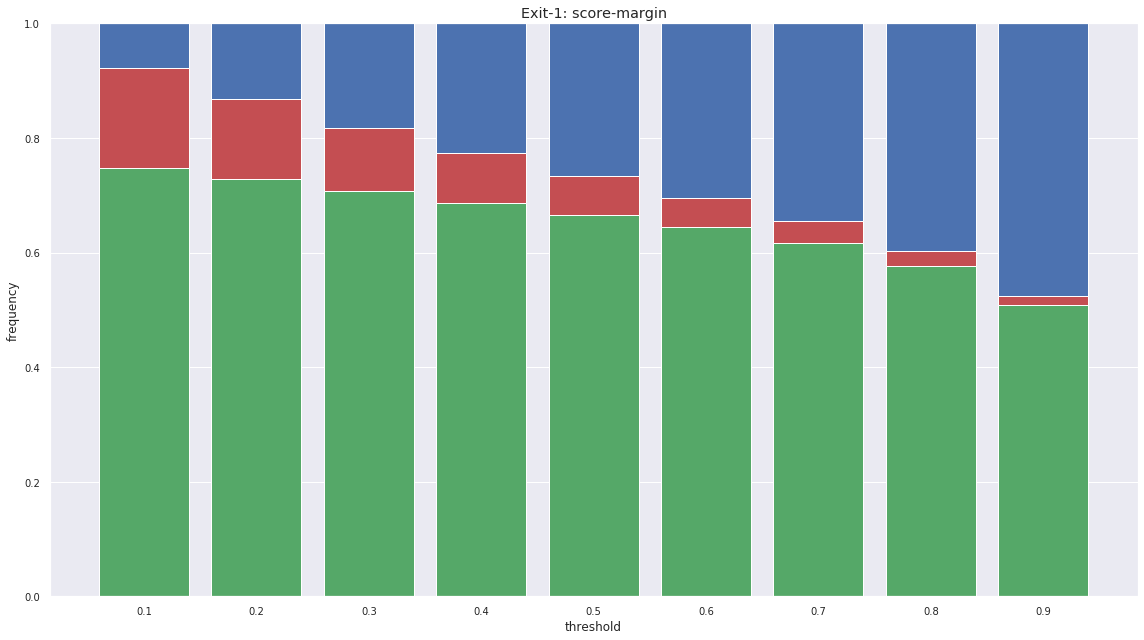

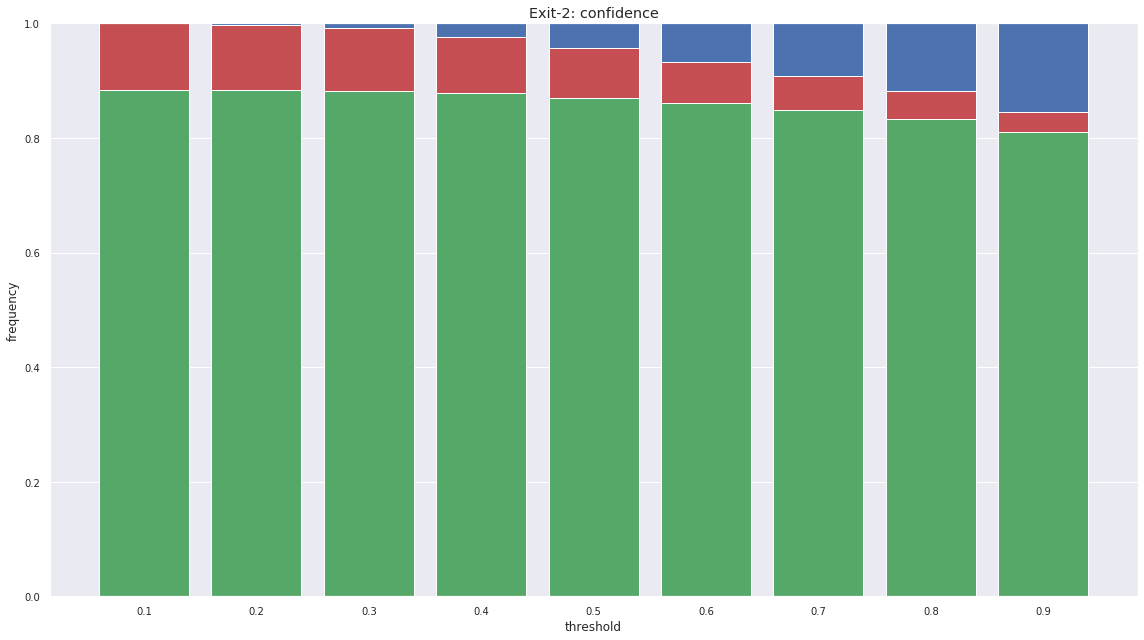

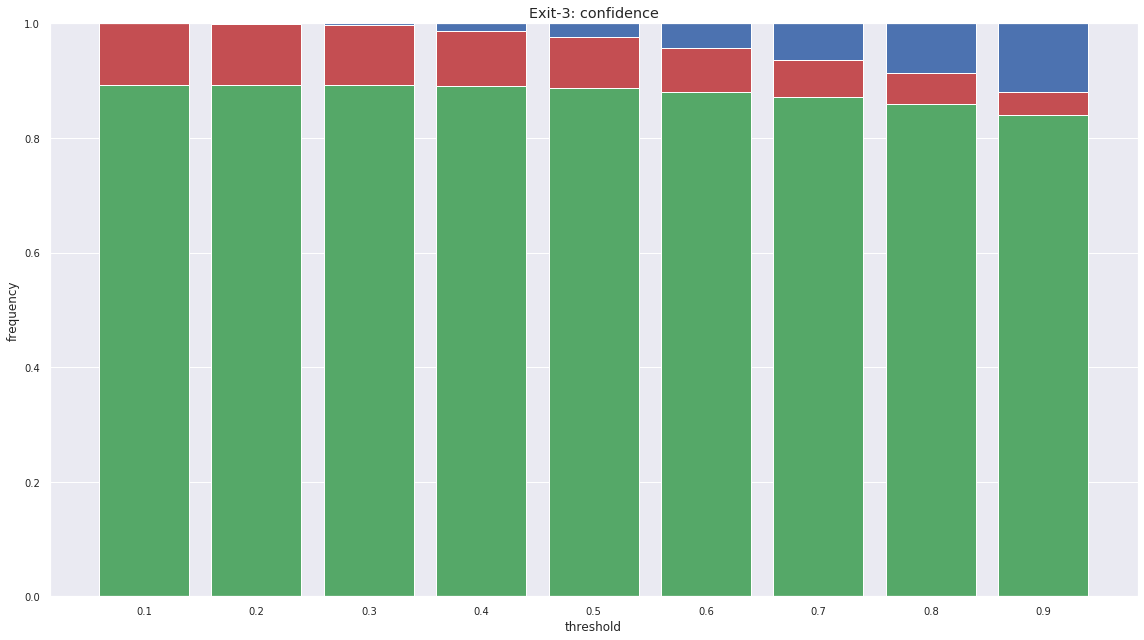

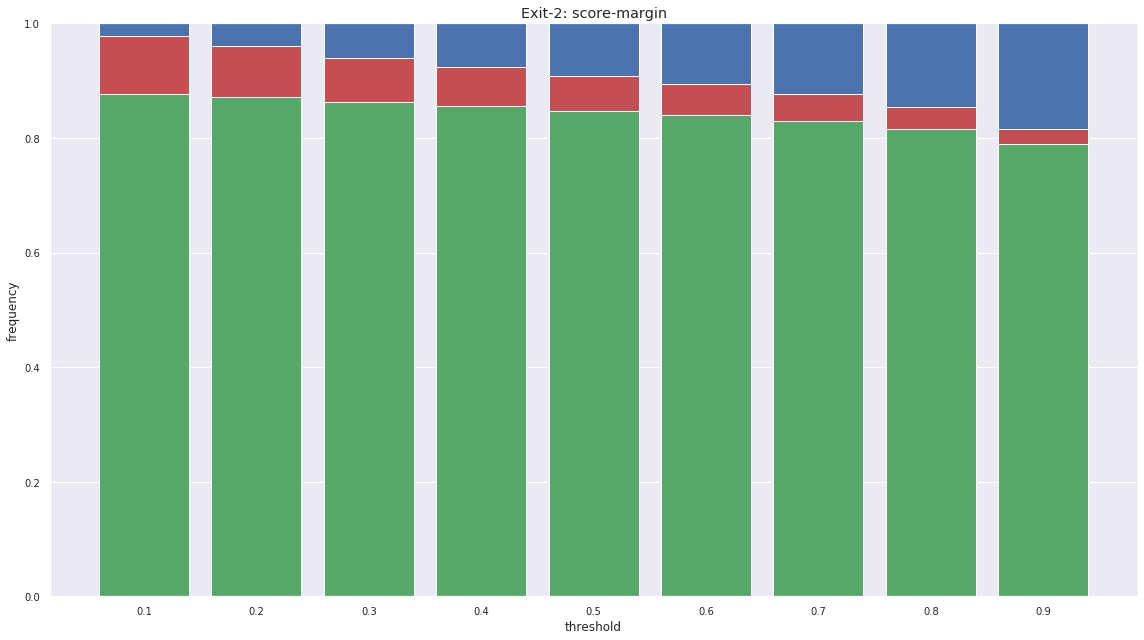

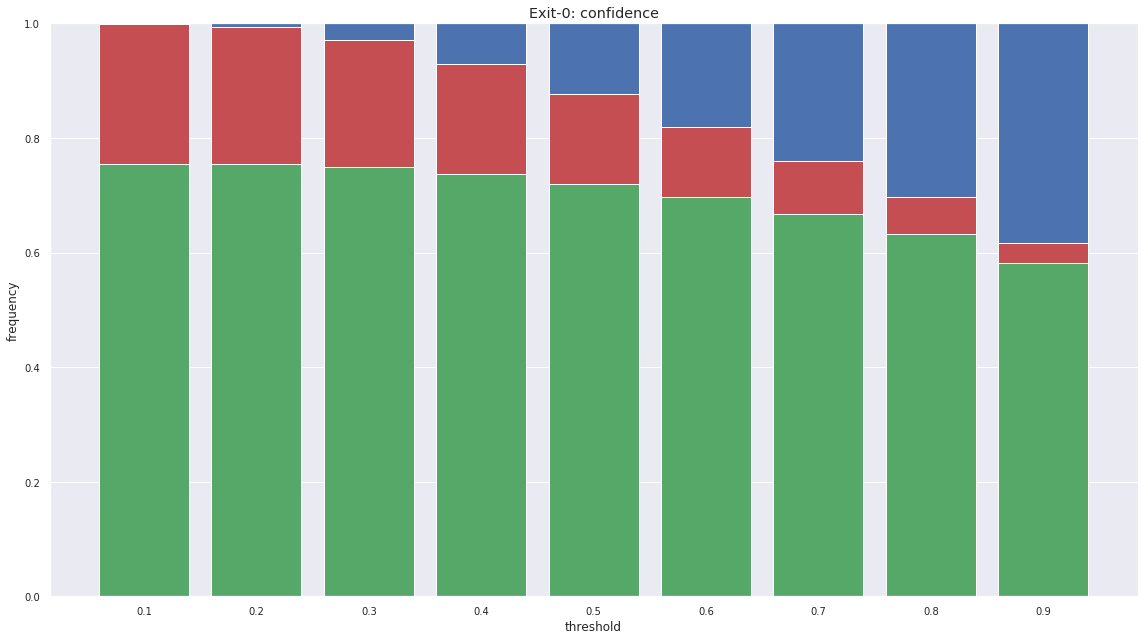

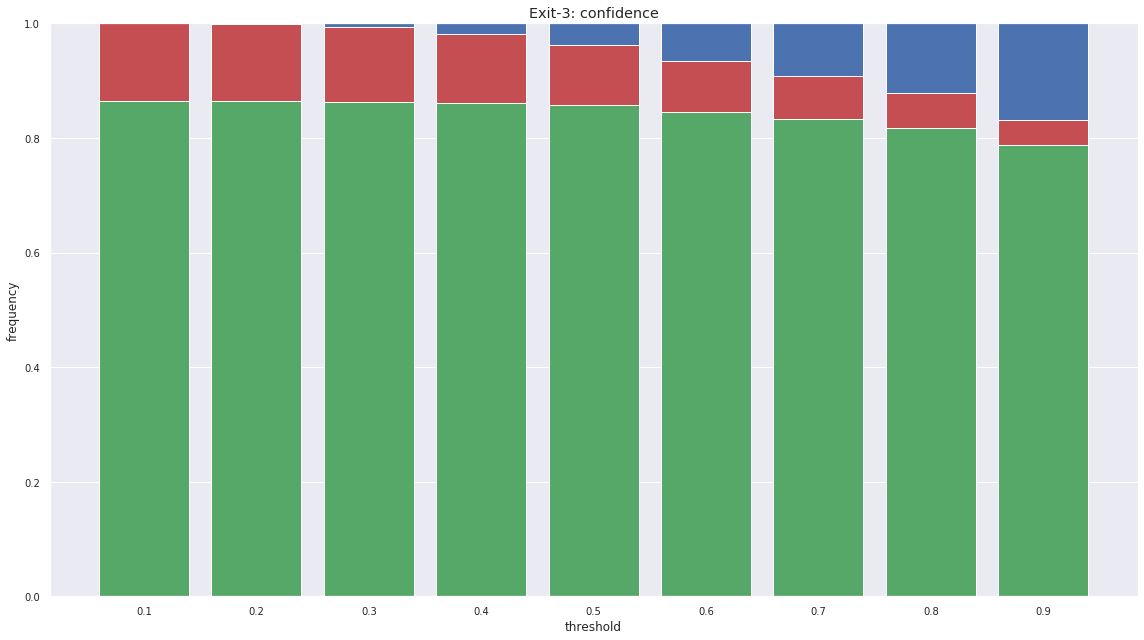

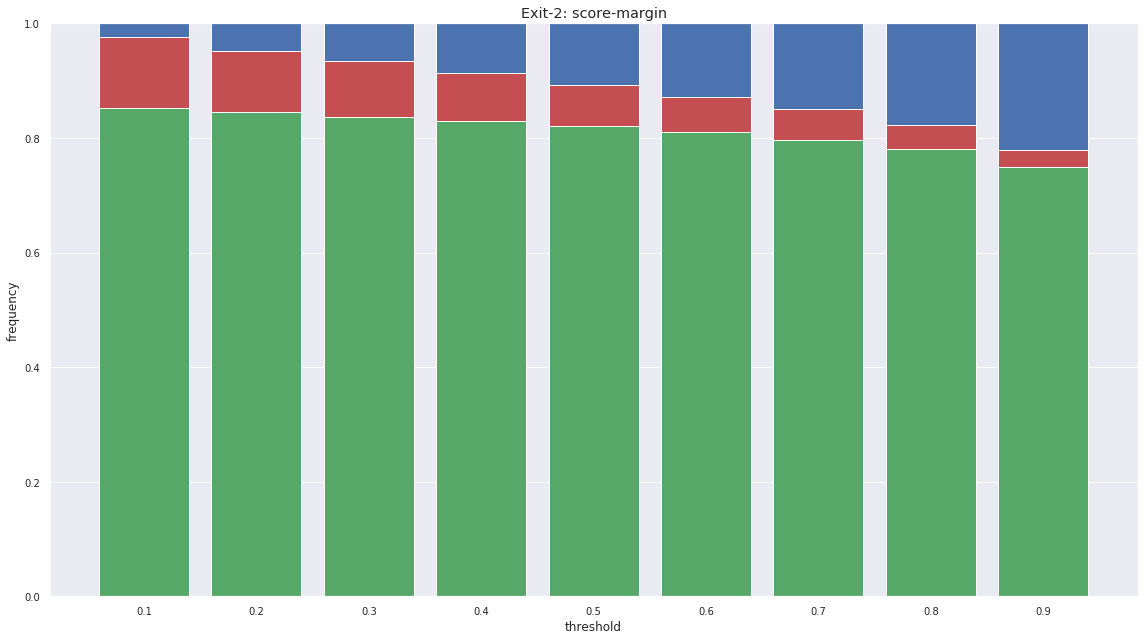

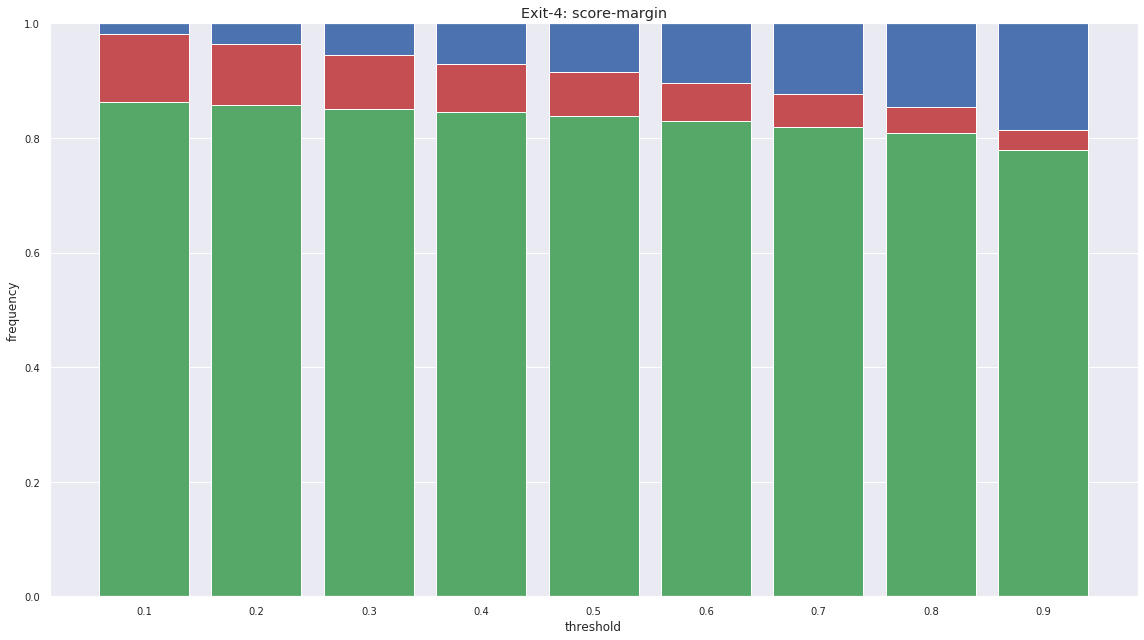

In [225]:
n_samples = 5000
n_thresholds = np.arange(9)



color_palette = sns.color_palette()



for model in output:
    for test in output[model]:
        for exit in range(len(output[model][test]['correct'])):
            fig, ax = plt.subplots(1,1, figsize=(16,9), sharex=True, sharey=True)
            plt.setp(ax, xticks=N, xticklabels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
            accuracy = np.array(output[model][test]['accuracy']['exit-{}'.format(exit)])
            correct = np.array(output[model][test]['correct']['exit-{}'.format(exit)])
            incorrect = np.array(output[model][test]['incorrect']['exit-{}'.format(exit)])
            not_exited = n_samples - (correct + incorrect) 

            # normalizing
            correct = correct / n_samples
            incorrect = incorrect / n_samples
            not_exited = not_exited / n_samples

            ax.bar(n_thresholds, correct, color=color_palette[2])
            ax.bar(n_thresholds, incorrect, bottom = correct, color=color_palette[3])
            ax.bar(n_thresholds, not_exited, bottom = correct + incorrect, color=color_palette[0])
            #ax.plot(n_thresholds, accuracy)

            ax.set_title('Exit-{}: {}'.format(exit, test))
            ax.set_ylim([0,1])
            ax.set(xlabel='threshold', ylabel='frequency')
            fig.tight_layout()
            #fig.subplots_adjust(left=0.15, top=0.95)
            plt.savefig('threshold_analysis_{}_{}_{}.png'.format(model, test, exit))

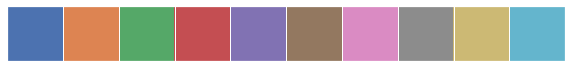

In [131]:
sns.palplot(color_palette)